# Bayesian neural networks
## Gelato: PyMC3 and Lasagne bridge

I was inspired by [@twieky](https://github.com/twiecki) and his great [post](http://twiecki.github.io/blog/2016/07/05/bayesian-deep-learning/) about bayesian neural networks. But I thought that that way of creating BNNs is not obvious and easy for people. That's why I decided to make a bridge for `PyMC3` and `Lasagne`.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import gelato
from gelato.layers.helper import get_output
import lasagne.updates as updates
import theano
import theano.tensor as tt
import numpy as np
import lasagne
import pymc3 as pm
import warnings
warnings.filterwarnings('ignore')

Using gpu device 0: Tesla K40m (CNMeM is enabled with initial size: 95.0% of memory, CuDNN 4007)


I will use his convolution bnn from the post as an example of how to use gelato API
## Load Data

In [4]:
import sys, os

def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

print("Loading data...")
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
total_size = X_train.shape[0]

Loading data...


In [5]:
input_var = theano.shared(X_train.astype(np.float32))
target_var = theano.shared(y_train.astype(np.float32))
ridx = gelato.random.tt_rng().uniform(low=0, high=total_size-1e-16, size=(128,)).astype('int32')
input_var=input_var[ridx]
target_var=target_var[ridx]

## Create priors for weights
Gelato has a flexible way to define a prior on weight instead of just shared variable. That allows to deal with uncertanty in weights and in predictions as well. 
### Disclamer
I have to note that Gelato has some overhead magic with wrappring lasagne layers. Espessially there is no need to use gelato layer if you pass gelato `Spec` class to lasagne layer to define a weight. But using them happens to be very convenient. There is a handy function `set_default_spec` that declares what prior to use if none specified.

## Hierarchical prior

In [6]:
from gelato.specs import NormalSpec, LognormalSpec, set_default_spec
# Now every layer without passed specs will use `NormalSpec(sd=hyper)` as a prior
hyper = LognormalSpec(sd=1).with_shape(())
set_default_spec(NormalSpec(sd=hyper))

## Network

In [49]:
with pm.Model() as model:
    network = gelato.layers.InputLayer(shape=(None, 1, 28, 28),
                                        input_var=input_var)

    network = gelato.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.tanh)

    # Max-pooling layer of factor 2 in both dimensions:
    network = gelato.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # Another convolution with 32 5x5 kernels, and another 2x2 pooling:
    network = gelato.layers.Conv2DLayer(
        network, num_filters=32, filter_size=(5, 5),
        nonlinearity=lasagne.nonlinearities.tanh)
    
    network = gelato.layers.MaxPool2DLayer(network, 
                                            pool_size=(2, 2))
    
    n_hid2 = 176
    network = gelato.layers.DenseLayer(
        network, num_units=n_hid2,
        nonlinearity=lasagne.nonlinearities.tanh,
    )
    
    n_hid3 = 64
    network = gelato.layers.DenseLayer(
        network, num_units=n_hid3,
        nonlinearity=lasagne.nonlinearities.tanh,
    )
    
    # Finally, we'll add the fully-connected output layer, of 10 softmax units:
    network = gelato.layers.DenseLayer(
        network, num_units=10,
        nonlinearity=lasagne.nonlinearities.softmax,
    )
    
    prediction = gelato.layers.get_output(network)
    
    likelihood = pm.Categorical('out', 
                   prediction,
                   observed=target_var,
                   total_size=total_size)

$$ELBO=pi*KL[q(w|mu,rho)||p(w)] + E_q[log p(D|w)]$$

Getting ELBO for model and optimizing it is quite easy and can be cone just in few lines. As we will perform batch training we have to say what population size we have for observed var or else we'll get invalid approximation.

In [50]:
model.vars

[Conv2DLayer_140365552325016_W:145_log__,
 Conv2DLayer_140365552325016_W,
 Conv2DLayer_140365552325016_b:149_log__,
 Conv2DLayer_140365552325016_b,
 Conv2DLayer_140365552325240_W:153_log__,
 Conv2DLayer_140365552325240_W,
 Conv2DLayer_140365552325240_b:157_log__,
 Conv2DLayer_140365552325240_b,
 DenseLayer_140365550068064_W:161_log__,
 DenseLayer_140365550068064_W,
 DenseLayer_140365550068064_b:165_log__,
 DenseLayer_140365550068064_b,
 DenseLayer_140365553311696_W:169_log__,
 DenseLayer_140365553311696_W,
 DenseLayer_140365553311696_b:173_log__,
 DenseLayer_140365553311696_b,
 DenseLayer_140365553342952_W:177_log__,
 DenseLayer_140365553342952_W,
 DenseLayer_140365553342952_b:181_log__,
 DenseLayer_140365553342952_b]

In [51]:
with model:
    advi = pm.ADVI()

In [53]:
advi.fit(60000)

Average Loss = 67.445: 100%|██████████| 60000/60000 [09:51<00:00, 101.39it/s]
Finished [100%]: Average Loss = 67.383


In [9]:
import pickle
#params = advi.approx.shared_params
#pickle.dump(params, open('params.pymc3','wb'))

In [10]:
#advi.approx.shared_params = pickle.load(open('params.pymc3','rb'))

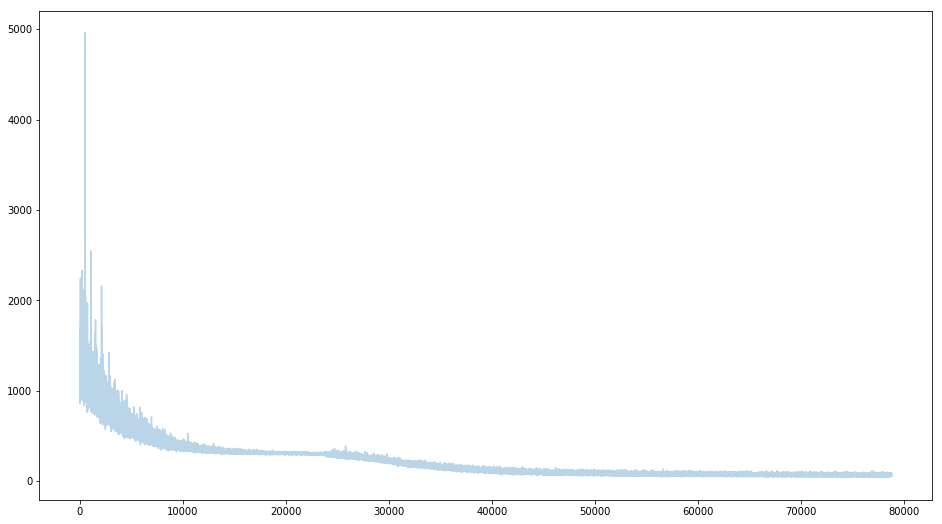

In [54]:
plt.figure(figsize=(16,9))
plt.plot(np.array(advi.hist), alpha=.3);

For getting uncertanty of our model there is a helper in `gelato.layers.get_output`. It will replace all nodes with gaussian optimization result or just means if `dererministic=True`

In [55]:
inpimg = tt.tensor4('input')
inpimg.tag.test_value = X_test[0][None,...]
it = tt.iscalar('i')
it.tag.test_value = 10

In [56]:
_prediction = gelato.layers.get_output(network)
prediction = advi.approx.apply_replacements(_prediction, deterministic=True, more_replacements={input_var:inpimg})
predictions = advi.approx.sample_node(_prediction, it, more_replacements={input_var:inpimg})

In [57]:
predictions_f = theano.function([inpimg, theano.In(it, 's', 10)], predictions)
prediction_f = theano.function([inpimg], prediction)

In [77]:
errors = np.argmax(prediction_f(X_test), axis=1) != y_test
y_pred = np.argmax(prediction_f(X_test), axis=1)
sampled_preds = predictions_f(X_test)

In [78]:
np.mean(errors)

0.041000000000000002

true: 9 prediction: 4


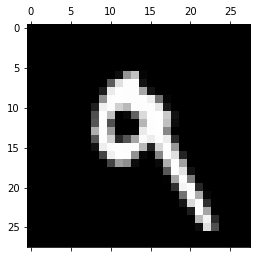

In [79]:
print('true:', y_test[errors][0],'prediction:', y_pred[errors][0])
plt.gray();plt.matshow(X_test[errors][0][0]);plt.show()

true: 3 prediction: 8


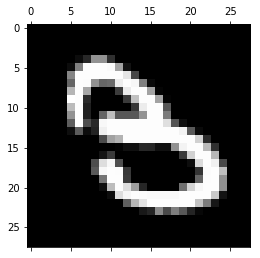

In [80]:
print('true:',y_test[errors][1],'prediction:', y_pred[errors][1])
plt.gray();plt.matshow(X_test[errors][1][0]);plt.show()

# Uncertanty
Let's calculate average variance in correct pedictions and wrong predictions. I don't use Chi squared statistics to illustrate the difference as [@twieky](https://github.com/twiecki) did. But still, this picture gives an evidence that mistakes are done with more quantity of uncertanty and thus can be potentially treated as problebatic examples 

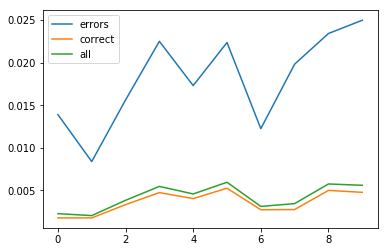

In [81]:
plt.plot(sampled_preds.var(0)[errors].mean(0), label='errors')
plt.plot(sampled_preds.var(0)[~errors].mean(0), label='correct')
plt.plot(sampled_preds.var(0).mean(0), label='all')
plt.legend()